C:\Users\26792\AppData\Local\Temp/ipykernel_35072/1203507231.py:12: RuntimeWarning: divide by zero encountered in log
  y = np.log(X)


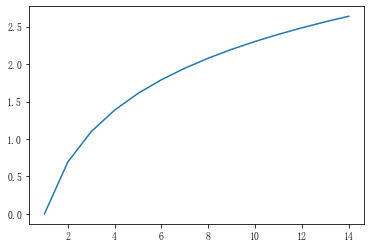

In [8]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt

mpl.rcParams['font.sans-serif'] = ['FangSong']
mpl.rcParams['axes.unicode_minus'] = False

X = range(0,15)
y = np.log(X)

plt.plot(X,y)
plt.show()

In [55]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 15 19:06:12 2022

@author: 26792
"""

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt

mpl.rcParams['font.sans-serif'] = ['FangSong']
mpl.rcParams['axes.unicode_minus'] = False

from IPython.display import display
df = pd.read_excel("D:datasets\mldata\RunData.XLS",sheet_name = '#1')

col_rename = []
for i in range(0,68):
    col_rename.append(df.iloc[1,i])
df.columns = col_rename
df = df.drop([0,1],axis='index').reset_index(drop=True)

X = df['联合循环功率'].values.astype('float32')
from sklearn.preprocessing import MinMaxScaler
# 归一化处理



scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X.reshape(-1, 1))

def create_dataset(dataset,look_back=60): # 每个的滑动窗口设置为2
    dataX, dataY=[], []
    for i in range(len(dataset)-look_back):
        a=dataset[i:(i+look_back)]
        dataX.append(a)    # 记录窗口的值
        dataY.append(dataset[i+look_back]) # 记录除了前面两个以外的所有值作为正确的标签
    return np.array(dataX), np.array(dataY)
#创建好输入与输出 data_Y作为正确的预测值
data_X, data_Y = create_dataset(X)

train_size = int(len(data_X) * 0.8)
test_size = len(data_X)-train_size

train_X = data_X[:train_size]
train_Y = data_Y[:train_size]

test_X = data_X[train_size:]
test_Y = data_Y[train_size:]
#print(train_X.shape)
#最后，我们需要将数据改变一下形状，因为 RNN 读入的数据维度是 (seq, batch, feature)，所以要重新改变一下数据的维度，这里只有一个序列，所以 batch 是 1，而输入的 feature 就是我们希望依据的几天，这里我们定的是两个天，所以 feature 就是 2.

train_X = train_X.reshape(-1,1,60)
train_Y = train_Y.reshape(-1,1,1)
test_X = test_X.reshape(-1,1,60)

#print(train_X.shape)
print(test_X.shape)

import torch 
from torch import nn
from torch.autograd import Variable
#lstm 网络
class lstm_reg(nn.Module):#括号中的是python的类继承语法，父类是nn.Module类 不是参数的意思
    def __init__(self,input_size,hidden_size, output_size=1,num_layers=3): # 构造函数
        #inpu_size 是输入的样本的特征维度， hidden_size 是LSTM层的神经元个数，
        #output_size是输出的特征维度
        super(lstm_reg,self).__init__()# super用于多层继承使用，必须要有的操作
 
        self.rnn = nn.LSTM(input_size,hidden_size,num_layers)# 两层LSTM网络，
        self.reg = nn.Linear(hidden_size,output_size)#把上一层总共hidden_size个的神经元的输出向量作为输入向量，然后回归到output_size维度的输出向量中
 
    def forward(self,x): #x是输入的数据
        x, _ = self.rnn(x)# 单个下划线表示不在意的变量，这里是LSTM网络输出的两个隐藏层状态
        s,b,h = x.shape
        x = x.view(s*b, h)
        x = self.reg(x)
        x = x.view(s,b,-1)#使用-1表示第三个维度自动根据原来的shape 和已经定了的s,b来确定
        return x
#我使用了GPU加速，如果不用的话需要把.cuda()给注释掉    
net = lstm_reg(60,100)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(),lr=1e-2)    

from torch.autograd import Variable
for e in range(20):
    var_x = Variable(torch.from_numpy(train_X)) 
    var_y = Variable(torch.from_numpy(train_Y))
 
    out = net(var_x)
    loss = criterion(out, var_y)
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e+1)%10 == 0:
        print('Epoch: {}, Loss:{:.5f}'.format(e+1, loss.item()))
#存储训练好的模型参数        



var_data = torch.from_numpy(test_X)#net在GPU上面，所以输入的测试集合也要转入到GPU上面
#print(var_data.shape)
pred_test = net(var_data) # 测试集的预测结果
#print(pred_test.shape)
pred_test = pred_test.view(-1).data.numpy()#先转移到cpu上才能转换为numpy
#print(pred_test.shape)
#乘以原来归一化的刻度放缩回到原来的值域 
origin_test_Y = scaler.inverse_transform(test_Y.reshape(-1, 1))
origin_pred_test = scaler.inverse_transform(pred_test.reshape(-1, 1))


#画图
plt.figure(figsize = (15,4))
plt.plot(origin_pred_test, 'r', label='prediction')
plt.plot(origin_test_Y, 'b', label='real')
plt.legend(loc='best')
plt.show()

#计算MSE
#loss = criterion(out, var_y)？
true_data = origin_test_Y
true_data = np.array(true_data)
true_data = np.squeeze(true_data)  # 从二维变成一维
MSE_loss = np.sum((true_data - origin_pred_test)**2)/len(true_data)

print(MSE_loss)
print(MSE_loss**0.5)

,骞垮窞,绾胯矾6,d1b5feda077818e286aefe5b1cbc75c6,7e017a9d22141cc1b536d417a69c4b43,骞垮窞.1,2014/12/29 8:00,鏅€氩崱
0,骞垮窞,绾胯矾6,4fe4beb30f21df1b16b0769a0ceac473,f983f75ad1146366dea7b4bd12b36294,骞垮窞,2014/12/29 9:00,鏅€氩崱
1,骞垮窞,绾胯矾6,4fe4beb30f21df1b16b0769a0ceac473,7615005a78528a56514375a2eb2486a2,骞垮窞,2014/12/29 9:00,鏅€氩崱
2,骞垮窞,绾胯矾11,78da304535276e90f941f644028848c2,e7921ba6f9fba313c2326d54bd26ffa5,骞垮窞,2014/12/28 13:00,鏅€氩崱
3,骞垮窞,绾胯矾11,78da304535276e90f941f644028848c2,040e0386b1ee6f8b7f03f1f0d4b355c0,骞垮窞,2014/12/28 13:00,鏅€氩崱
4,骞垮窞,绾胯矾6,d6d5806e8ea3db1b7ce2d61d995bb8da,393591054157b0a725e285f011293a85,骞垮窞,2014/12/29 6:00,钥佷汉鍗?


In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt

mpl.rcParams['font.sans-serif'] = ['FangSong']
mpl.rcParams['axes.unicode_minus'] = False

from IPython.display import display
df = pd.read_excel("D:datasets\mldata\RunData.XLS",sheet_name = '#1')
df.head()

,UnitNum,DetailTime,Tag1,Tag2,Tag3,Tag4,Tag5,Tag6,Tag7,Tag8,...,Tag57,Tag58,Tag59,Tag60,Tag61,Tag62,Tag63,Tag64,Tag65,Tag66
0,单位,NaT,t/h,t/h,℃,kPa,℃,NaN,kPa,℃,...,kPa,℃,%,r/min,h,MW,NaN,NaN,NaN,NaN
1,说明,2014-12-15 06:24:08.000,空气质量流量,天然气质量流量,大气温度,大气压力,压气机进口空气温度,压气机压比,压气机进口空气压力,压气机出口空气温度,...,凝汽器压力,天然气加热器进口燃气温度,大气湿度,转速,运行小时数,联合循环功率,联合循环功率因素,联合循环频率,联合循环励磁电流,联合+A3+AT3:AT3:BP3
2,1,2014-12-29 08:16:08.000,2342.718896,49.262232,5.810559,101.983559,5.166665,15.798577,101.192748,379.742126,...,5.240098,11.046362,58.938324,3000.36499,35199.289062,376.40625,0.377813,49.506954,1729.717773,547.51239
3,1,2014-12-25 08:56:08.000,2342.678906,48.26388,5.146191,103.060494,4.682627,15.78881,102.283836,373.842743,...,6.11194,12.450884,65.561295,2999.987549,35124.476562,376.387146,0.643795,49.5746,1701.042114,539.792358
4,1,2014-12-29 08:17:07.797,2343.090234,49.262579,6.192057,101.983486,5.138834,15.798322,101.190896,379.542938,...,5.24446,11.071339,57.544735,3000.166016,35199.304688,376.319122,0.37971,49.508347,1706.046997,547.743958


In [2]:
col_rename = []
for i in range(0,68):
    col_rename.append(df.iloc[1,i])
df.columns = col_rename
df = df.drop([0,1],axis='index').reset_index(drop=True)
df.head()

,说明,2014-12-15 06:24:08,空气质量流量,天然气质量流量,大气温度,大气压力,压气机进口空气温度,压气机压比,压气机进口空气压力,压气机出口空气温度,...,凝汽器压力,天然气加热器进口燃气温度,大气湿度,转速,运行小时数,联合循环功率,联合循环功率因素,联合循环频率,联合循环励磁电流,联合+A3+AT3:AT3:BP3
0,1,2014-12-29 08:16:08.000,2342.718896,49.262232,5.810559,101.983559,5.166665,15.798577,101.192748,379.742126,...,5.240098,11.046362,58.938324,3000.36499,35199.289062,376.40625,0.377813,49.506954,1729.717773,547.51239
1,1,2014-12-25 08:56:08.000,2342.678906,48.26388,5.146191,103.060494,4.682627,15.78881,102.283836,373.842743,...,6.11194,12.450884,65.561295,2999.987549,35124.476562,376.387146,0.643795,49.5746,1701.042114,539.792358
2,1,2014-12-29 08:17:07.797,2343.090234,49.262579,6.192057,101.983486,5.138834,15.798322,101.190896,379.542938,...,5.24446,11.071339,57.544735,3000.166016,35199.304688,376.319122,0.37971,49.508347,1706.046997,547.743958
3,1,2014-12-25 08:57:08.000,2338.553101,48.2672,4.52215,103.060957,4.720131,15.788899,102.289666,373.534363,...,6.115463,12.45035,63.492619,3001.228027,35124.492188,376.30957,0.645896,49.575893,1683.886597,538.26593
4,1,2014-12-25 08:58:07.797,2340.647314,48.27052,5.741402,103.061421,4.759082,15.788988,102.302531,373.56601,...,6.118979,12.449816,66.488007,3000.366211,35124.507812,376.232025,0.647996,49.57719,1684.195312,539.347046


In [10]:
df.iloc[0]

说明                                       1
2014-12-15 06:24:08    2014-12-29 08:16:08
空气质量流量                         2342.718896
天然气质量流量                          49.262232
大气温度                              5.810559
                              ...         
联合循环功率                           376.40625
联合循环功率因素                          0.377813
联合循环频率                           49.506954
联合循环励磁电流                       1729.717773
联合+A3+AT3:AT3:BP3                547.51239
Name: 0, Length: 68, dtype: object

In [20]:
col = df.columns
col =list(col)
col[1] = '时间'
df.columns = col
df.columns

Index(['说明', '时间', '空气质量流量', '天然气质量流量', '大气温度', '大气压力', '压气机进口空气温度', '压气机压比',
       '压气机进口空气压力', '压气机出口空气温度', '压气机出口空气压力', '大气压力与压气机进口压力之差', '透平出口烟气压力',
       '透平出口烟气温度', '透平压比', '燃烧室进口天然气温度', '余热锅炉入口烟气温度', '余热锅炉入口烟气压力',
       '余热锅炉出口烟气温度', '余热锅炉出口烟气压力', '低压给水温度', '低压给水压力', '低压给水流量', '低压过热器出口蒸汽温度',
       '低压过热器出口蒸汽压力', '低压过热器出口蒸汽流量', '再热器出口蒸汽温度', '再热器出口蒸汽压力', '中压过热器出口蒸汽温度',
       '中压过热器出口蒸汽压力', '中压过热器出口蒸汽流量', '再热器进口蒸汽温度', '再热器进口蒸汽压力', '高压过热器出口蒸汽温度',
       '高压过热器出口蒸汽压力', '高压过热器出口蒸汽流量', '天然气加热器进口热水温度', '天然气加热器进口热水压力',
       '天然气加热器进口热水流量', '余热锅炉高压蒸发器出口烟气温度', '高压汽包压力', '高压省煤器出口水压力', '高压省煤器出口水温度',
       '余热锅炉中压蒸发器出口烟气温度', '中压汽包压力', '中压省煤器出口水压力', '中压省煤器出口水温度',
       '余热锅炉低压蒸发器出口烟气温度', '低压汽包压力', '低压省煤器出口水压力', '低压省煤器出口水温度', '高压缸排气温度',
       '高压缸排气压力', '低压缸进口蒸汽温度', '低压缸进口蒸汽压力', '低压缸排气温度', '低压缸排气压力', '凝汽器温度',
       '凝汽器压力', '天然气加热器进口燃气温度', '大气湿度', '转速', '运行小时数', '联合循环功率', '联合循环功率因素',
       '联合循环频率', '联合循环励磁电流', '联合+A3+AT3:AT3:BP3'],
      dtype='object')

In [42]:
data = df[['时间','大气温度']]

data = data.sort_values('时间',ascending=True)
data.head()

,时间,大气温度
782,2014-12-24 18:39:07.797,10.807205
799,2014-12-24 18:40:07.797,11.11462
813,2014-12-24 18:41:07.797,11.236652
831,2014-12-24 18:42:07.797,10.373202
845,2014-12-24 18:43:07.797,10.109568


In [43]:
data.index = data['时间']
data = data.drop('时间', axis='columns')
data.head()

,大气温度
时间,
2014-12-24 18:39:07.797,10.807205
2014-12-24 18:40:07.797,11.11462
2014-12-24 18:41:07.797,11.236652
2014-12-24 18:42:07.797,10.373202
2014-12-24 18:43:07.797,10.109568


In [49]:
data['2014-12-30':'2014-12-30'].head()

,大气温度
时间,
2014-12-30 00:00:07.797,9.690475
2014-12-30 00:01:07.797,8.179338
2014-12-30 00:02:07.797,10.048985
2014-12-30 00:03:07.797,9.674817
2014-12-30 00:04:07.797,9.365923


<AxesSubplot:xlabel='时间'>

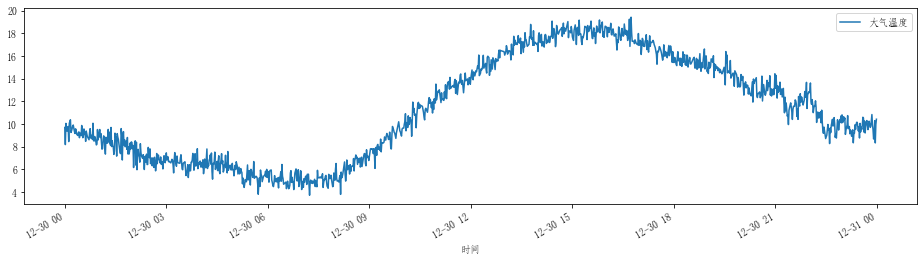

In [50]:
data['2014-12-30':'2014-12-30'].plot(figsize=(16,4),legend=True)